<a href="https://colab.research.google.com/github/SUBHASH-KANDHWAY/MACHINE-LEARNING-PROJECTS/blob/master/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
#You now want to set some variables:

# Let Keras know that we are using tensorflow as our backend engine
os.environ["KERAS_BACKEND"] = "tensorflow"

# To make sure that we can reproduce the experiment and get the same results
np.random.seed(10)

# The dimension of our random noise vector.
random_dim = 100

In [ ]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [ ]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [ ]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [ ]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [ ]:
def train(epochs=1, batch_size=1024):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

if __name__ == '__main__':
    train(400, 128)

  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:19, 24.26it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:18, 24.54it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:17, 26.21it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:18, 25.47it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:18, 25.22it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:18, 25.51it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:18, 25.83it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:17, 26.40it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:20, 22.88it/s]

--------------- Epoch 10 ---------------


  1%|          | 3/468 [00:00<00:19, 24.08it/s]

--------------- Epoch 11 ---------------


  1%|          | 3/468 [00:00<00:18, 25.12it/s]

--------------- Epoch 12 ---------------


  1%|          | 3/468 [00:00<00:18, 24.83it/s]

--------------- Epoch 13 ---------------


  1%|          | 3/468 [00:00<00:20, 22.86it/s]

--------------- Epoch 14 ---------------


  1%|          | 3/468 [00:00<00:18, 24.87it/s]

--------------- Epoch 15 ---------------


  1%|          | 3/468 [00:00<00:18, 25.75it/s]

--------------- Epoch 16 ---------------


  1%|          | 3/468 [00:00<00:20, 22.88it/s]

--------------- Epoch 17 ---------------


  1%|          | 3/468 [00:00<00:19, 24.32it/s]

--------------- Epoch 18 ---------------


  1%|          | 3/468 [00:00<00:18, 24.92it/s]

--------------- Epoch 19 ---------------


  1%|          | 3/468 [00:00<00:19, 24.22it/s]

--------------- Epoch 20 ---------------


  1%|          | 3/468 [00:00<00:21, 22.03it/s]

--------------- Epoch 21 ---------------


  1%|          | 3/468 [00:00<00:19, 23.84it/s]

--------------- Epoch 22 ---------------


  1%|          | 3/468 [00:00<00:17, 26.97it/s]

--------------- Epoch 23 ---------------


  1%|          | 3/468 [00:00<00:19, 24.23it/s]

--------------- Epoch 24 ---------------


  1%|          | 3/468 [00:00<00:20, 22.94it/s]

--------------- Epoch 25 ---------------


  1%|          | 3/468 [00:00<00:20, 22.88it/s]

--------------- Epoch 26 ---------------


  1%|          | 3/468 [00:00<00:17, 26.21it/s]

--------------- Epoch 27 ---------------


  1%|          | 3/468 [00:00<00:17, 26.02it/s]

--------------- Epoch 28 ---------------


  1%|          | 3/468 [00:00<00:20, 23.04it/s]

--------------- Epoch 29 ---------------


  1%|          | 3/468 [00:00<00:17, 26.30it/s]

--------------- Epoch 30 ---------------


  1%|          | 3/468 [00:00<00:18, 25.37it/s]

--------------- Epoch 31 ---------------


  1%|          | 3/468 [00:00<00:18, 24.56it/s]

--------------- Epoch 32 ---------------


  1%|          | 3/468 [00:00<00:18, 25.04it/s]

--------------- Epoch 33 ---------------


  1%|          | 3/468 [00:00<00:18, 25.77it/s]

--------------- Epoch 34 ---------------


  1%|          | 3/468 [00:00<00:19, 24.02it/s]

--------------- Epoch 35 ---------------


  1%|          | 3/468 [00:00<00:20, 22.87it/s]

--------------- Epoch 36 ---------------


  1%|          | 3/468 [00:00<00:18, 25.71it/s]

--------------- Epoch 37 ---------------


  1%|          | 3/468 [00:00<00:20, 22.90it/s]

--------------- Epoch 38 ---------------


  1%|          | 3/468 [00:00<00:18, 25.26it/s]

--------------- Epoch 39 ---------------


  1%|          | 3/468 [00:00<00:19, 23.72it/s]

--------------- Epoch 40 ---------------


  1%|          | 3/468 [00:00<00:18, 25.23it/s]

--------------- Epoch 41 ---------------


  1%|          | 3/468 [00:00<00:18, 24.50it/s]

--------------- Epoch 42 ---------------


  1%|          | 3/468 [00:00<00:18, 25.77it/s]

--------------- Epoch 43 ---------------


  1%|          | 3/468 [00:00<00:17, 26.76it/s]

--------------- Epoch 44 ---------------


  1%|          | 3/468 [00:00<00:18, 25.27it/s]

--------------- Epoch 45 ---------------


  1%|          | 3/468 [00:00<00:18, 25.55it/s]

--------------- Epoch 46 ---------------


  1%|          | 3/468 [00:00<00:19, 24.42it/s]

--------------- Epoch 47 ---------------


  1%|          | 3/468 [00:00<00:17, 26.94it/s]

--------------- Epoch 48 ---------------


  1%|          | 3/468 [00:00<00:18, 25.64it/s]

--------------- Epoch 49 ---------------


  1%|          | 3/468 [00:00<00:18, 25.57it/s]

--------------- Epoch 50 ---------------


  1%|          | 3/468 [00:00<00:17, 26.52it/s]

--------------- Epoch 51 ---------------


  1%|          | 3/468 [00:00<00:17, 27.08it/s]

--------------- Epoch 52 ---------------


  1%|          | 3/468 [00:00<00:17, 25.98it/s]

--------------- Epoch 53 ---------------


  1%|          | 3/468 [00:00<00:17, 26.93it/s]

--------------- Epoch 54 ---------------


  1%|          | 3/468 [00:00<00:19, 24.23it/s]

--------------- Epoch 55 ---------------


  1%|          | 3/468 [00:00<00:18, 25.22it/s]

--------------- Epoch 56 ---------------


  1%|          | 3/468 [00:00<00:18, 25.49it/s]

--------------- Epoch 57 ---------------


  1%|          | 3/468 [00:00<00:18, 25.14it/s]

--------------- Epoch 58 ---------------


  1%|          | 3/468 [00:00<00:18, 25.70it/s]

--------------- Epoch 59 ---------------


  1%|          | 3/468 [00:00<00:17, 26.04it/s]

--------------- Epoch 60 ---------------


  1%|          | 3/468 [00:00<00:18, 25.56it/s]

--------------- Epoch 61 ---------------


  1%|          | 3/468 [00:00<00:17, 26.21it/s]

--------------- Epoch 62 ---------------


  1%|          | 3/468 [00:00<00:17, 26.30it/s]

--------------- Epoch 63 ---------------


  1%|          | 3/468 [00:00<00:17, 27.31it/s]

--------------- Epoch 64 ---------------


  1%|          | 3/468 [00:00<00:18, 25.03it/s]

--------------- Epoch 65 ---------------


  1%|          | 3/468 [00:00<00:17, 26.54it/s]

--------------- Epoch 66 ---------------


  1%|          | 3/468 [00:00<00:19, 24.44it/s]

--------------- Epoch 67 ---------------


  1%|          | 3/468 [00:00<00:17, 26.84it/s]

--------------- Epoch 68 ---------------


  1%|          | 3/468 [00:00<00:17, 26.25it/s]

--------------- Epoch 69 ---------------


  1%|          | 3/468 [00:00<00:16, 27.55it/s]

--------------- Epoch 70 ---------------


  1%|          | 3/468 [00:00<00:17, 26.77it/s]

--------------- Epoch 71 ---------------


  1%|          | 3/468 [00:00<00:18, 25.65it/s]

--------------- Epoch 72 ---------------


  1%|          | 3/468 [00:00<00:17, 26.73it/s]

--------------- Epoch 73 ---------------


  1%|          | 3/468 [00:00<00:18, 24.97it/s]

--------------- Epoch 74 ---------------


  1%|          | 3/468 [00:00<00:18, 25.26it/s]

--------------- Epoch 75 ---------------


  1%|          | 3/468 [00:00<00:20, 23.16it/s]

--------------- Epoch 76 ---------------


  1%|          | 3/468 [00:00<00:17, 26.38it/s]

--------------- Epoch 77 ---------------


  1%|          | 3/468 [00:00<00:17, 26.41it/s]

--------------- Epoch 78 ---------------


  1%|          | 3/468 [00:00<00:19, 23.64it/s]

--------------- Epoch 79 ---------------


  1%|          | 3/468 [00:00<00:19, 24.40it/s]

--------------- Epoch 80 ---------------


  1%|          | 3/468 [00:00<00:18, 25.68it/s]

--------------- Epoch 81 ---------------


  1%|          | 3/468 [00:00<00:17, 25.88it/s]

--------------- Epoch 82 ---------------


  1%|          | 3/468 [00:00<00:18, 25.19it/s]

--------------- Epoch 83 ---------------


  1%|          | 3/468 [00:00<00:18, 25.11it/s]

--------------- Epoch 84 ---------------


  1%|          | 3/468 [00:00<00:18, 24.53it/s]

--------------- Epoch 85 ---------------


  1%|          | 3/468 [00:00<00:18, 25.82it/s]

--------------- Epoch 86 ---------------


  1%|          | 3/468 [00:00<00:17, 26.65it/s]

--------------- Epoch 87 ---------------


  1%|          | 3/468 [00:00<00:18, 25.64it/s]

--------------- Epoch 88 ---------------


  1%|          | 3/468 [00:00<00:17, 26.76it/s]

--------------- Epoch 89 ---------------


  1%|          | 3/468 [00:00<00:18, 25.45it/s]

--------------- Epoch 90 ---------------


  1%|          | 3/468 [00:00<00:18, 24.74it/s]

--------------- Epoch 91 ---------------


  1%|          | 3/468 [00:00<00:18, 24.53it/s]

--------------- Epoch 92 ---------------


  1%|          | 3/468 [00:00<00:17, 26.59it/s]

--------------- Epoch 93 ---------------


  1%|          | 3/468 [00:00<00:16, 27.41it/s]

--------------- Epoch 94 ---------------


  1%|          | 3/468 [00:00<00:18, 25.68it/s]

--------------- Epoch 95 ---------------


  1%|          | 3/468 [00:00<00:17, 27.13it/s]

--------------- Epoch 96 ---------------


  1%|          | 3/468 [00:00<00:18, 25.27it/s]

--------------- Epoch 97 ---------------


  1%|          | 3/468 [00:00<00:18, 25.08it/s]

--------------- Epoch 98 ---------------


  1%|          | 3/468 [00:00<00:20, 23.25it/s]

--------------- Epoch 99 ---------------


  1%|          | 3/468 [00:00<00:18, 25.25it/s]

--------------- Epoch 100 ---------------


  1%|          | 3/468 [00:00<00:18, 25.58it/s]

--------------- Epoch 101 ---------------


  1%|          | 3/468 [00:00<00:18, 25.17it/s]

--------------- Epoch 102 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 103 ---------------


  1%|          | 3/468 [00:00<00:17, 26.76it/s]

--------------- Epoch 104 ---------------


  1%|          | 3/468 [00:00<00:17, 26.55it/s]

--------------- Epoch 105 ---------------


  1%|          | 3/468 [00:00<00:17, 27.01it/s]

--------------- Epoch 106 ---------------


  1%|          | 3/468 [00:00<00:20, 22.29it/s]

--------------- Epoch 107 ---------------


  1%|          | 3/468 [00:00<00:17, 27.18it/s]

--------------- Epoch 108 ---------------


  1%|          | 3/468 [00:00<00:17, 26.71it/s]

--------------- Epoch 109 ---------------


  1%|          | 3/468 [00:00<00:17, 26.89it/s]

--------------- Epoch 110 ---------------


  1%|          | 3/468 [00:00<00:19, 23.46it/s]

--------------- Epoch 111 ---------------


  1%|          | 3/468 [00:00<00:17, 27.29it/s]

--------------- Epoch 112 ---------------


  1%|          | 3/468 [00:00<00:18, 25.39it/s]

--------------- Epoch 113 ---------------


  1%|          | 3/468 [00:00<00:17, 26.13it/s]

--------------- Epoch 114 ---------------


  1%|          | 3/468 [00:00<00:18, 24.95it/s]

--------------- Epoch 115 ---------------


  1%|          | 3/468 [00:00<00:18, 25.68it/s]

--------------- Epoch 116 ---------------


  1%|          | 3/468 [00:00<00:17, 26.36it/s]

--------------- Epoch 117 ---------------


  1%|          | 3/468 [00:00<00:18, 25.14it/s]

--------------- Epoch 118 ---------------


  1%|          | 3/468 [00:00<00:17, 26.71it/s]

--------------- Epoch 119 ---------------


  1%|          | 3/468 [00:00<00:17, 27.08it/s]

--------------- Epoch 120 ---------------


  1%|          | 3/468 [00:00<00:17, 26.16it/s]

--------------- Epoch 121 ---------------


  1%|          | 3/468 [00:00<00:18, 25.63it/s]

--------------- Epoch 122 ---------------


  1%|          | 3/468 [00:00<00:17, 26.64it/s]

--------------- Epoch 123 ---------------


  1%|          | 3/468 [00:00<00:17, 26.80it/s]

--------------- Epoch 124 ---------------


  1%|          | 3/468 [00:00<00:20, 22.30it/s]

--------------- Epoch 125 ---------------


  1%|          | 3/468 [00:00<00:17, 27.15it/s]

--------------- Epoch 126 ---------------


  1%|          | 3/468 [00:00<00:17, 26.68it/s]

--------------- Epoch 127 ---------------


  1%|          | 3/468 [00:00<00:17, 26.92it/s]

--------------- Epoch 128 ---------------


  1%|          | 3/468 [00:00<00:18, 25.43it/s]

--------------- Epoch 129 ---------------


  1%|          | 3/468 [00:00<00:17, 27.11it/s]

--------------- Epoch 130 ---------------


  1%|          | 3/468 [00:00<00:17, 25.98it/s]

--------------- Epoch 131 ---------------


  1%|          | 3/468 [00:00<00:18, 25.32it/s]

--------------- Epoch 132 ---------------


  1%|          | 3/468 [00:00<00:18, 25.57it/s]

--------------- Epoch 133 ---------------


  1%|          | 3/468 [00:00<00:17, 26.44it/s]

--------------- Epoch 134 ---------------


  1%|          | 3/468 [00:00<00:16, 27.45it/s]

--------------- Epoch 135 ---------------


  1%|          | 3/468 [00:00<00:17, 25.86it/s]

--------------- Epoch 136 ---------------


  1%|          | 3/468 [00:00<00:16, 27.46it/s]

--------------- Epoch 137 ---------------


  1%|          | 3/468 [00:00<00:19, 23.98it/s]

--------------- Epoch 138 ---------------


  1%|          | 3/468 [00:00<00:16, 27.41it/s]

--------------- Epoch 139 ---------------


  1%|          | 3/468 [00:00<00:17, 26.71it/s]

--------------- Epoch 140 ---------------


  1%|          | 3/468 [00:00<00:18, 24.94it/s]

--------------- Epoch 141 ---------------


  1%|          | 3/468 [00:00<00:17, 27.20it/s]

--------------- Epoch 142 ---------------


  1%|          | 3/468 [00:00<00:18, 25.27it/s]

--------------- Epoch 143 ---------------


  1%|          | 3/468 [00:00<00:17, 26.13it/s]

--------------- Epoch 144 ---------------


  1%|          | 3/468 [00:00<00:16, 27.38it/s]

--------------- Epoch 145 ---------------


  1%|          | 3/468 [00:00<00:17, 26.69it/s]

--------------- Epoch 146 ---------------


  1%|          | 3/468 [00:00<00:17, 26.56it/s]

--------------- Epoch 147 ---------------


  1%|          | 3/468 [00:00<00:18, 24.56it/s]

--------------- Epoch 148 ---------------


  1%|          | 3/468 [00:00<00:18, 25.37it/s]

--------------- Epoch 149 ---------------


  1%|          | 3/468 [00:00<00:17, 25.97it/s]

--------------- Epoch 150 ---------------


  1%|          | 3/468 [00:00<00:17, 26.00it/s]

--------------- Epoch 151 ---------------


  1%|          | 3/468 [00:00<00:18, 25.59it/s]

--------------- Epoch 152 ---------------


  1%|          | 3/468 [00:00<00:16, 27.68it/s]

--------------- Epoch 153 ---------------


  1%|          | 3/468 [00:00<00:17, 27.01it/s]

--------------- Epoch 154 ---------------


  1%|          | 3/468 [00:00<00:17, 26.00it/s]

--------------- Epoch 155 ---------------


  1%|          | 3/468 [00:00<00:17, 25.87it/s]

--------------- Epoch 156 ---------------


  1%|          | 3/468 [00:00<00:17, 27.31it/s]

--------------- Epoch 157 ---------------


  1%|          | 3/468 [00:00<00:18, 25.83it/s]

--------------- Epoch 158 ---------------


  1%|          | 3/468 [00:00<00:17, 26.08it/s]

--------------- Epoch 159 ---------------


  1%|          | 3/468 [00:00<00:16, 27.38it/s]

--------------- Epoch 160 ---------------


  1%|          | 3/468 [00:00<00:18, 25.18it/s]

--------------- Epoch 161 ---------------


  1%|          | 3/468 [00:00<00:17, 26.36it/s]

--------------- Epoch 162 ---------------


  1%|          | 3/468 [00:00<00:18, 24.56it/s]

--------------- Epoch 163 ---------------


  1%|          | 3/468 [00:00<00:17, 26.59it/s]

--------------- Epoch 164 ---------------


  1%|          | 3/468 [00:00<00:17, 27.23it/s]

--------------- Epoch 165 ---------------


  1%|          | 3/468 [00:00<00:18, 25.56it/s]

--------------- Epoch 166 ---------------


  1%|          | 3/468 [00:00<00:18, 25.08it/s]

--------------- Epoch 167 ---------------


  1%|          | 3/468 [00:00<00:17, 26.26it/s]

--------------- Epoch 168 ---------------


  1%|          | 3/468 [00:00<00:17, 27.24it/s]

--------------- Epoch 169 ---------------


  1%|          | 3/468 [00:00<00:18, 25.63it/s]

--------------- Epoch 170 ---------------


  1%|          | 3/468 [00:00<00:17, 25.89it/s]

--------------- Epoch 171 ---------------


  1%|          | 3/468 [00:00<00:16, 27.48it/s]

--------------- Epoch 172 ---------------


  1%|          | 3/468 [00:00<00:16, 27.42it/s]

--------------- Epoch 173 ---------------


  1%|          | 3/468 [00:00<00:18, 25.55it/s]

--------------- Epoch 174 ---------------


  1%|          | 3/468 [00:00<00:18, 25.81it/s]

--------------- Epoch 175 ---------------


  1%|          | 3/468 [00:00<00:16, 27.43it/s]

--------------- Epoch 176 ---------------


  1%|          | 3/468 [00:00<00:17, 27.18it/s]

--------------- Epoch 177 ---------------


  1%|          | 3/468 [00:00<00:17, 26.27it/s]

--------------- Epoch 178 ---------------


  1%|          | 3/468 [00:00<00:16, 27.44it/s]

--------------- Epoch 179 ---------------


  1%|          | 3/468 [00:00<00:16, 27.37it/s]

--------------- Epoch 180 ---------------


  1%|          | 3/468 [00:00<00:18, 24.57it/s]

--------------- Epoch 181 ---------------


  1%|          | 3/468 [00:00<00:18, 24.49it/s]

--------------- Epoch 182 ---------------


  1%|          | 3/468 [00:00<00:17, 27.27it/s]

--------------- Epoch 183 ---------------


  1%|          | 3/468 [00:00<00:16, 27.37it/s]

--------------- Epoch 184 ---------------


  1%|          | 3/468 [00:00<00:19, 24.07it/s]

--------------- Epoch 185 ---------------


  1%|          | 3/468 [00:00<00:18, 25.58it/s]

--------------- Epoch 186 ---------------


  1%|          | 3/468 [00:00<00:17, 26.75it/s]

--------------- Epoch 187 ---------------


  1%|          | 3/468 [00:00<00:17, 26.11it/s]

--------------- Epoch 188 ---------------


  1%|          | 3/468 [00:00<00:17, 26.21it/s]

--------------- Epoch 189 ---------------


  1%|          | 3/468 [00:00<00:18, 25.81it/s]

--------------- Epoch 190 ---------------


  1%|          | 3/468 [00:00<00:17, 26.95it/s]

--------------- Epoch 191 ---------------


  1%|          | 3/468 [00:00<00:17, 26.80it/s]

--------------- Epoch 192 ---------------


  1%|          | 3/468 [00:00<00:18, 24.60it/s]

--------------- Epoch 193 ---------------


  1%|          | 3/468 [00:00<00:17, 27.17it/s]

--------------- Epoch 194 ---------------


  1%|          | 3/468 [00:00<00:17, 27.27it/s]

--------------- Epoch 195 ---------------


  1%|          | 3/468 [00:00<00:19, 23.76it/s]

--------------- Epoch 196 ---------------


  1%|          | 3/468 [00:00<00:18, 25.78it/s]

--------------- Epoch 197 ---------------


  1%|          | 3/468 [00:00<00:17, 27.31it/s]

--------------- Epoch 198 ---------------


  1%|          | 3/468 [00:00<00:17, 25.97it/s]

--------------- Epoch 199 ---------------


  1%|          | 3/468 [00:00<00:19, 23.44it/s]

--------------- Epoch 200 ---------------


  1%|          | 3/468 [00:00<00:18, 25.03it/s]

--------------- Epoch 201 ---------------


  1%|          | 3/468 [00:00<00:17, 27.34it/s]

--------------- Epoch 202 ---------------


  1%|          | 3/468 [00:00<00:17, 26.11it/s]

--------------- Epoch 203 ---------------


  1%|          | 3/468 [00:00<00:17, 26.98it/s]

--------------- Epoch 204 ---------------


  1%|          | 3/468 [00:00<00:17, 25.98it/s]

--------------- Epoch 205 ---------------


  1%|          | 3/468 [00:00<00:17, 26.41it/s]

--------------- Epoch 206 ---------------


  1%|          | 3/468 [00:00<00:18, 25.44it/s]

--------------- Epoch 207 ---------------


  1%|          | 3/468 [00:00<00:17, 25.96it/s]

--------------- Epoch 208 ---------------


  1%|          | 3/468 [00:00<00:17, 26.46it/s]

--------------- Epoch 209 ---------------


  1%|          | 3/468 [00:00<00:19, 23.89it/s]

--------------- Epoch 210 ---------------


  1%|          | 3/468 [00:00<00:18, 25.48it/s]

--------------- Epoch 211 ---------------


  1%|          | 3/468 [00:00<00:17, 26.67it/s]

--------------- Epoch 212 ---------------


  1%|          | 3/468 [00:00<00:20, 23.04it/s]

--------------- Epoch 213 ---------------


  1%|          | 3/468 [00:00<00:18, 24.69it/s]

--------------- Epoch 214 ---------------


  1%|          | 3/468 [00:00<00:20, 22.77it/s]

--------------- Epoch 215 ---------------


  1%|          | 3/468 [00:00<00:18, 25.71it/s]

--------------- Epoch 216 ---------------


  1%|          | 3/468 [00:00<00:17, 26.78it/s]

--------------- Epoch 217 ---------------


  1%|          | 3/468 [00:00<00:18, 24.99it/s]

--------------- Epoch 218 ---------------


  1%|          | 3/468 [00:00<00:19, 24.13it/s]

--------------- Epoch 219 ---------------


  1%|          | 3/468 [00:00<00:17, 26.44it/s]

--------------- Epoch 220 ---------------


  1%|          | 3/468 [00:00<00:18, 25.15it/s]

--------------- Epoch 221 ---------------


  1%|          | 3/468 [00:00<00:18, 24.51it/s]

--------------- Epoch 222 ---------------


  1%|          | 3/468 [00:00<00:18, 25.14it/s]

--------------- Epoch 223 ---------------


  1%|          | 3/468 [00:00<00:18, 25.55it/s]

--------------- Epoch 224 ---------------


  1%|          | 3/468 [00:00<00:19, 24.31it/s]

--------------- Epoch 225 ---------------


  1%|          | 3/468 [00:00<00:18, 25.70it/s]

--------------- Epoch 226 ---------------


  1%|          | 3/468 [00:00<00:17, 26.06it/s]

--------------- Epoch 227 ---------------


  1%|          | 3/468 [00:00<00:17, 26.43it/s]

--------------- Epoch 228 ---------------


  1%|          | 3/468 [00:00<00:18, 25.41it/s]

--------------- Epoch 229 ---------------


  1%|          | 3/468 [00:00<00:17, 26.57it/s]

--------------- Epoch 230 ---------------


  1%|          | 3/468 [00:00<00:17, 26.69it/s]

--------------- Epoch 231 ---------------


  1%|          | 3/468 [00:00<00:19, 23.92it/s]

--------------- Epoch 232 ---------------


  1%|          | 3/468 [00:00<00:21, 21.36it/s]

--------------- Epoch 233 ---------------


  1%|          | 3/468 [00:00<00:18, 24.77it/s]

--------------- Epoch 234 ---------------


  1%|          | 3/468 [00:00<00:17, 26.63it/s]

--------------- Epoch 235 ---------------


  1%|          | 3/468 [00:00<00:18, 25.42it/s]

--------------- Epoch 236 ---------------


  1%|          | 3/468 [00:00<00:17, 26.84it/s]

--------------- Epoch 237 ---------------


  1%|          | 3/468 [00:00<00:17, 26.77it/s]

--------------- Epoch 238 ---------------


  1%|          | 3/468 [00:00<00:17, 26.46it/s]

--------------- Epoch 239 ---------------


  1%|          | 3/468 [00:00<00:18, 25.31it/s]

--------------- Epoch 240 ---------------


  1%|          | 3/468 [00:00<00:18, 25.82it/s]

--------------- Epoch 241 ---------------


  1%|          | 3/468 [00:00<00:17, 26.79it/s]

--------------- Epoch 242 ---------------


  1%|          | 3/468 [00:00<00:17, 27.17it/s]

--------------- Epoch 243 ---------------


  1%|          | 3/468 [00:00<00:21, 21.67it/s]

--------------- Epoch 244 ---------------


  1%|          | 3/468 [00:00<00:17, 25.99it/s]

--------------- Epoch 245 ---------------


  1%|          | 3/468 [00:00<00:17, 26.96it/s]

--------------- Epoch 246 ---------------


  1%|          | 3/468 [00:00<00:17, 26.41it/s]

--------------- Epoch 247 ---------------


  1%|          | 3/468 [00:00<00:18, 25.81it/s]

--------------- Epoch 248 ---------------


  1%|          | 3/468 [00:00<00:18, 25.22it/s]

--------------- Epoch 249 ---------------


  1%|          | 3/468 [00:00<00:17, 26.15it/s]

--------------- Epoch 250 ---------------


  1%|          | 3/468 [00:00<00:18, 25.58it/s]

--------------- Epoch 251 ---------------


  1%|          | 3/468 [00:00<00:18, 25.47it/s]

--------------- Epoch 252 ---------------


  1%|          | 3/468 [00:00<00:16, 27.39it/s]

--------------- Epoch 253 ---------------


  1%|          | 3/468 [00:00<00:17, 26.22it/s]

--------------- Epoch 254 ---------------


  1%|          | 3/468 [00:00<00:19, 23.80it/s]

--------------- Epoch 255 ---------------


  1%|          | 3/468 [00:00<00:18, 24.94it/s]

--------------- Epoch 256 ---------------


  1%|          | 3/468 [00:00<00:17, 26.87it/s]

--------------- Epoch 257 ---------------


  1%|          | 3/468 [00:00<00:18, 25.56it/s]

--------------- Epoch 258 ---------------


  1%|          | 3/468 [00:00<00:16, 27.36it/s]

--------------- Epoch 259 ---------------


  1%|          | 3/468 [00:00<00:17, 26.87it/s]

--------------- Epoch 260 ---------------


  0%|          | 2/468 [00:00<00:24, 19.20it/s]

--------------- Epoch 261 ---------------


  1%|          | 3/468 [00:00<00:18, 25.25it/s]

--------------- Epoch 262 ---------------


  1%|          | 3/468 [00:00<00:16, 27.42it/s]

--------------- Epoch 263 ---------------


  1%|          | 3/468 [00:00<00:17, 27.19it/s]

--------------- Epoch 264 ---------------


  1%|          | 3/468 [00:00<00:16, 27.50it/s]

--------------- Epoch 265 ---------------


  1%|          | 3/468 [00:00<00:17, 27.22it/s]

--------------- Epoch 266 ---------------


  1%|          | 3/468 [00:00<00:16, 27.56it/s]

--------------- Epoch 267 ---------------


  1%|          | 3/468 [00:00<00:18, 24.96it/s]

--------------- Epoch 268 ---------------


  1%|          | 3/468 [00:00<00:18, 25.44it/s]

--------------- Epoch 269 ---------------


  1%|          | 3/468 [00:00<00:17, 26.98it/s]

--------------- Epoch 270 ---------------


  1%|          | 3/468 [00:00<00:17, 26.48it/s]

--------------- Epoch 271 ---------------


  1%|          | 3/468 [00:00<00:19, 23.70it/s]

--------------- Epoch 272 ---------------


  1%|          | 3/468 [00:00<00:17, 27.31it/s]

--------------- Epoch 273 ---------------


  1%|          | 3/468 [00:00<00:17, 25.85it/s]

--------------- Epoch 274 ---------------


  1%|          | 3/468 [00:00<00:17, 27.04it/s]

--------------- Epoch 275 ---------------


  1%|          | 3/468 [00:00<00:18, 25.02it/s]

--------------- Epoch 276 ---------------


  1%|          | 3/468 [00:00<00:17, 27.22it/s]

--------------- Epoch 277 ---------------


  1%|          | 3/468 [00:00<00:19, 24.01it/s]

--------------- Epoch 278 ---------------


  1%|          | 3/468 [00:00<00:19, 23.78it/s]

--------------- Epoch 279 ---------------


  1%|          | 3/468 [00:00<00:18, 24.51it/s]

--------------- Epoch 280 ---------------


  1%|          | 3/468 [00:00<00:18, 24.56it/s]

--------------- Epoch 281 ---------------


  1%|          | 3/468 [00:00<00:17, 26.37it/s]

--------------- Epoch 282 ---------------


  1%|          | 3/468 [00:00<00:17, 26.03it/s]

--------------- Epoch 283 ---------------


  1%|          | 3/468 [00:00<00:17, 26.96it/s]

--------------- Epoch 284 ---------------


  1%|          | 3/468 [00:00<00:18, 25.10it/s]

--------------- Epoch 285 ---------------


  1%|          | 3/468 [00:00<00:17, 26.25it/s]

--------------- Epoch 286 ---------------


  1%|          | 3/468 [00:00<00:17, 26.04it/s]

--------------- Epoch 287 ---------------


  1%|          | 3/468 [00:00<00:17, 26.92it/s]

--------------- Epoch 288 ---------------


  1%|          | 3/468 [00:00<00:16, 27.74it/s]

--------------- Epoch 289 ---------------


  1%|          | 3/468 [00:00<00:18, 24.92it/s]

--------------- Epoch 290 ---------------


  1%|          | 3/468 [00:00<00:17, 26.70it/s]

--------------- Epoch 291 ---------------


  1%|          | 3/468 [00:00<00:18, 25.21it/s]

--------------- Epoch 292 ---------------


  1%|          | 3/468 [00:00<00:17, 26.53it/s]

--------------- Epoch 293 ---------------


  1%|          | 3/468 [00:00<00:17, 27.14it/s]

--------------- Epoch 294 ---------------


  1%|          | 3/468 [00:00<00:18, 24.67it/s]

--------------- Epoch 295 ---------------


  1%|          | 3/468 [00:00<00:16, 27.50it/s]

--------------- Epoch 296 ---------------


  1%|          | 3/468 [00:00<00:17, 26.24it/s]

--------------- Epoch 297 ---------------


  1%|          | 3/468 [00:00<00:17, 26.44it/s]

--------------- Epoch 298 ---------------


  1%|          | 3/468 [00:00<00:16, 27.41it/s]

--------------- Epoch 299 ---------------


  1%|          | 3/468 [00:00<00:17, 26.19it/s]

--------------- Epoch 300 ---------------


  1%|          | 3/468 [00:00<00:17, 26.24it/s]

--------------- Epoch 301 ---------------


  1%|          | 3/468 [00:00<00:16, 27.41it/s]

--------------- Epoch 302 ---------------


  1%|          | 3/468 [00:00<00:17, 26.22it/s]

--------------- Epoch 303 ---------------


  1%|          | 3/468 [00:00<00:17, 26.03it/s]

--------------- Epoch 304 ---------------


  1%|          | 3/468 [00:00<00:16, 27.52it/s]

--------------- Epoch 305 ---------------


  1%|          | 3/468 [00:00<00:17, 26.68it/s]

--------------- Epoch 306 ---------------


  1%|          | 3/468 [00:00<00:18, 25.82it/s]

--------------- Epoch 307 ---------------


  1%|          | 3/468 [00:00<00:17, 25.98it/s]

--------------- Epoch 308 ---------------


  1%|          | 3/468 [00:00<00:16, 27.84it/s]

--------------- Epoch 309 ---------------


  1%|          | 3/468 [00:00<00:17, 26.11it/s]

--------------- Epoch 310 ---------------


  1%|          | 3/468 [00:00<00:16, 27.59it/s]

--------------- Epoch 311 ---------------


  1%|          | 3/468 [00:00<00:20, 23.20it/s]

--------------- Epoch 312 ---------------


  1%|          | 3/468 [00:00<00:17, 26.28it/s]

--------------- Epoch 313 ---------------


  1%|          | 3/468 [00:00<00:17, 26.19it/s]

--------------- Epoch 314 ---------------


  1%|          | 3/468 [00:00<00:17, 25.86it/s]

--------------- Epoch 315 ---------------


  1%|          | 3/468 [00:00<00:16, 27.78it/s]

--------------- Epoch 316 ---------------


  1%|          | 3/468 [00:00<00:17, 27.17it/s]

--------------- Epoch 317 ---------------


  1%|          | 3/468 [00:00<00:17, 26.52it/s]

--------------- Epoch 318 ---------------


  1%|          | 3/468 [00:00<00:17, 26.12it/s]

--------------- Epoch 319 ---------------


  1%|          | 3/468 [00:00<00:17, 26.62it/s]

--------------- Epoch 320 ---------------


  1%|          | 3/468 [00:00<00:18, 25.28it/s]

--------------- Epoch 321 ---------------


  1%|          | 3/468 [00:00<00:17, 26.67it/s]

--------------- Epoch 322 ---------------


  1%|          | 3/468 [00:00<00:18, 25.29it/s]

--------------- Epoch 323 ---------------


  1%|          | 3/468 [00:00<00:17, 26.89it/s]

--------------- Epoch 324 ---------------


  1%|          | 3/468 [00:00<00:17, 26.69it/s]

--------------- Epoch 325 ---------------


  1%|          | 3/468 [00:00<00:18, 25.61it/s]

--------------- Epoch 326 ---------------


 12%|█▏        | 57/468 [00:02<00:16, 24.69it/s]


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7fb665a17b70> (for post_execute):


KeyboardInterrupt: ignored

***GAN ALTERNATIVE***

In [22]:
import tensorflow as tf
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

In [23]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [24]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [25]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [26]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [27]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

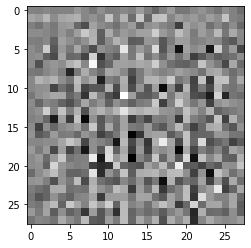

In [28]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [29]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [30]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00114999]], shape=(1, 1), dtype=float32)


In [31]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [32]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [33]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [34]:
#Save checkpoints
#his notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [35]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [36]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [37]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [38]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
train(train_dataset, EPOCHS)